In [1]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = '/root'
# APP_PATH = '.'


# 標準モジュール(install不要)
import os
import random

# import time
# import copy
# from collections import defaultdict
import torch
# import shutil
# import pandas as pd
from skimage import io, transform # scikit-image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils # 現時点では使ってない
from torch import nn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# import zipfile


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = APP_PATH + '/data/img'
CHECKPOINT_PATH = APP_PATH + '/data/model'
CHECKPOINT_PATH_UNet = CHECKPOINT_PATH + '/UNet'

# os.chdir(APP_PATH)

In [2]:
# ファイルの実行(ノートブック側でランタイムの再接続 or reloadをする)
# importで実行するときはファイルのパスを通す必要がある
# sys.path.append(APP_PATH + '/bin')

# setupなどのOSに関するコマンド実行はその定義ファイルをコマンドで実行
# 関数などのモジュールはimportで扱えるようにして実行
# !python bin/setup.py

# はじめから256にresizeされている
IMG_HEIGHT = 256
IMG_WIDTH = 256

NUM_EPOCHS = 20

In [3]:
#画像データ拡張の関数
def get_train_transform():
    
   return alb.Compose(
       [
        #リサイズ(元画像ですでにしているが)
        alb.Resize(IMG_HEIGHT, IMG_WIDTH),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        alb.HorizontalFlip(p=0.25),
        #垂直フリップ
        alb.VerticalFlip(p=0.25),
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
            
            # debug
            # print(f'image_folder: {image_folder}')
            # print(f'mask_folder: {mask_folder}')
            # print(f'image_path: {image_path}')
            # print(f'mask_path: {mask_path}')
            
            #画像データの取得
            # 3次元の処理を2次元に変更するのがいろいろめんどくさいから3次元の型で扱うことにする
            ## exec img
            # img = io.imread(image_path)[:,:,:3].astype('float32')
            img = io.imread(image_path)
            # TODO: 正答率がでたら比較としてfloat32でも試してみる
            # print(f'2d img.shape: {img.shape}') # 白黒なのでチャネル数が省略されて2次元データになっている
            img = self.conv_2D_to_3Darray(img)
            # print(f'3d img.shape: {img.shape}')


            ## exec mask
            # img = transform.resize(img,(256,256))
            ## mask = io.imread(mask_path)
            # maskの量が2つ以上になったらここの関数を実行してすべてを得る
            # mask = self.get_mask(mask_folder, 256, 256).astype('float32')
            mask = self.get_mask(mask_folder, IMG_HEIGHT, IMG_WIDTH) # nint8でOK?
            # print(f'calced mask.shape: {mask.shape}')

            # 前処理をするためにひとつにまとめる
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return (img,mask)
        
        def conv_2D_to_3Darray(self, arr):
            # print(f'exec conv_2D_to_3Darray')
            image = Image.fromarray(arr)
            image = image.convert("RGB")
            # 変換するならここでfloat32にする
            arr = np.asarray(image, np.uint8)
            # print(f'to3d arr shape: {arr.shape}')
            return arr

        def conv_3D_to_2Darray(self, arr):
            # print(f'exec conv_3D_to_2Darray')
            image = Image.fromarray(arr)
            image = image.convert("L")
            arr = np.asarray(image, np.uint8) # 変換するならここでfloat32にする
            # print(f'to2d arr shape: {arr.shape}')
            # arr = np.transpose(arr, (2, 0, 1))
            # print(f'arr transpose shape: {arr.shape}')
            return arr

        #マスクデータの取得
        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            # print(f'len(os.listdir(mask_folder)): {len(os.listdir(mask_folder))}')
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    # RGBからLへ
                    mask_ = self.conv_3D_to_2Darray(mask_)
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

# データセットを確認する
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


# 辞書型のときに要素を取得するマジックメソッド　以下と同じ意味
# image, mask = train_dataset.__getitem__(0)
image, mask = train_dataset[0]
print(image.shape)
print(mask.shape)

#Print total number of unique images.
# フォルダーの長さを表示　以下と同じ意味
train_dataset.__len__()
print(len(train_dataset))


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
60


[39, 11, 57]


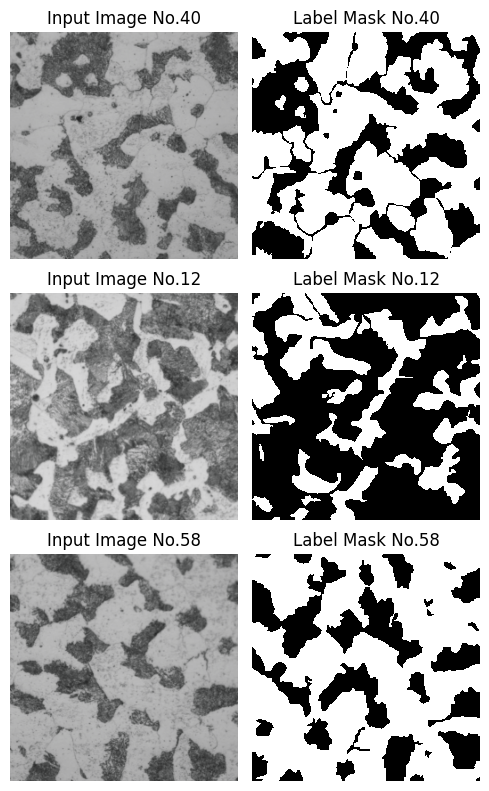

In [4]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, num_range, predict=None):
    #TODO:表示時に水平・垂直クリップがかるからかからないようにする(Predictedのほうも)
    images = random.sample(range(0, num_range), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset[i]
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

num_range = len(train_dataset)
visualize_dataset(3, num_range)

In [5]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 45
Length of validation　data: 15


In [6]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )



In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice


In [8]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [9]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()

valid_loss_min = np.Inf

best_model_file = '/best_model.pth'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(NUM_EPOCHS):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    ## 容量をとるので必要になったら保存する
    # checkpoint_file = "/checkpoint_{}_weight.pth".format(epoch+1)
    # checkpointの保存
    # torch.save(checkpoint, CHECKPOINT_PATH_UNet + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        torch.save(checkpoint, CHECKPOINT_PATH_UNet + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.06282478279473813, IoU: 0.8817780284420643: 100%|███████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Train Loss: 0.16209585878813002, Train IOU: 0.7328462382846236
Valid Loss: 0.06585304233771466, Valid IOU: 0.8766364077219329
Validation loss decreased (inf --> 0.065853).  Saving model ...



Epoch: 2, loss: 0.05671842868624255, IoU: 0.8926520326179821: 100%|███████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


Train Loss: 0.0847437132411101, Train IOU: 0.84507364294961
Valid Loss: 0.05795322929179253, Valid IOU: 0.8906266922037864
Validation loss decreased (0.065853 --> 0.057953).  Saving model ...



Epoch: 3, loss: 0.12640944986646485, IoU: 0.7755537935450414: 100%|███████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Train Loss: 0.08405848160815696, Train IOU: 0.8458659274169282
Valid Loss: 0.07416894366873472, Valid IOU: 0.861907188755646



Epoch: 4, loss: 0.09148937538812818, IoU: 0.8323590755625604: 100%|███████████████████████████| 5/5 [00:00<00:00,  5.26it/s]


Train Loss: 0.07981287633749379, Train IOU: 0.8523329660387742
Valid Loss: 0.054663181301515706, Valid IOU: 0.8964173957657877
Validation loss decreased (0.057953 --> 0.054663).  Saving model ...



Epoch: 5, loss: 0.1741037181158822, IoU: 0.7034278383315706: 100%|████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


Train Loss: 0.08449095390312093, Train IOU: 0.847185805151172
Valid Loss: 0.06436060181872355, Valid IOU: 0.8790697084480456



Epoch: 6, loss: 0.0769065096477346, IoU: 0.8571717749225889: 100%|████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Train Loss: 0.0642545105400785, Train IOU: 0.8793228484236522
Valid Loss: 0.05871956891745023, Valid IOU: 0.8890794434816642



Epoch: 7, loss: 0.1373920481686577, IoU: 0.7584092953244057: 100%|████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]


Train Loss: 0.07146846181336922, Train IOU: 0.8683298399824337
Valid Loss: 0.04419926212420444, Valid IOU: 0.9153764438743673
Validation loss decreased (0.054663 --> 0.044199).  Saving model ...



Epoch: 8, loss: 0.06462790187587586, IoU: 0.8785908892218058: 100%|███████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Train Loss: 0.0641651011378043, Train IOU: 0.8797897801785233
Valid Loss: 0.044840040509444956, Valid IOU: 0.9141950794281053



Epoch: 9, loss: 0.0446817968038834, IoU: 0.9144587121673434: 100%|████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Train Loss: 0.05937566256397906, Train IOU: 0.8884154128034545
Valid Loss: 0.04111689953775405, Valid IOU: 0.9210436080876765
Validation loss decreased (0.044199 --> 0.041117).  Saving model ...



Epoch: 10, loss: 0.12860474741219818, IoU: 0.7721000111330222: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


Train Loss: 0.07570975916169956, Train IOU: 0.8605702670853063
Valid Loss: 0.046875240639759064, Valid IOU: 0.9104603765488299



Epoch: 11, loss: 0.07247251184190595, IoU: 0.8648499390603763: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


Train Loss: 0.06450724903190941, Train IOU: 0.8793200144441101
Valid Loss: 0.044178370361896147, Valid IOU: 0.9154266359573627



Epoch: 12, loss: 0.052720812599502564, IoU: 0.8998391676474601: 100%|█████████████████████████| 5/5 [00:01<00:00,  4.86it/s]


Train Loss: 0.06320004947941008, Train IOU: 0.8822140089157487
Valid Loss: 0.04354043934984836, Valid IOU: 0.9166344587127828



Epoch: 13, loss: 0.17721358873890758, IoU: 0.6989279596004586: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


Train Loss: 0.07767283664788979, Train IOU: 0.8597151149624043
Valid Loss: 0.04706931297578376, Valid IOU: 0.9101805316480736



Epoch: 14, loss: 0.04550081927617278, IoU: 0.9129589839267203: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.09it/s]


Train Loss: 0.05715036308642787, Train IOU: 0.8920966278448578
Valid Loss: 0.03985290452129109, Valid IOU: 0.9234172113128185
Validation loss decreased (0.041117 --> 0.039853).  Saving model ...



Epoch: 15, loss: 0.06657609076383997, IoU: 0.8751594920309385: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.21it/s]


Train Loss: 0.055939523232308816, Train IOU: 0.8942435199999427
Valid Loss: 0.03920630614173187, Valid IOU: 0.9245901082710617
Validation loss decreased (0.039853 --> 0.039206).  Saving model ...



Epoch: 16, loss: 0.04063004819027194, IoU: 0.921912755634271: 100%|███████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Train Loss: 0.05226845124573613, Train IOU: 0.9008934411307379
Valid Loss: 0.0436926899169891, Valid IOU: 0.9162971054741228



Epoch: 17, loss: 0.04513391954342105, IoU: 0.9136305470902287: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


Train Loss: 0.05260266005023388, Train IOU: 0.9001551395553331
Valid Loss: 0.039726390858308536, Valid IOU: 0.923618524829915



Epoch: 18, loss: 0.044280952021990894, IoU: 0.9151936079447908: 100%|█████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


Train Loss: 0.05625197960010868, Train IOU: 0.8940949059006394
Valid Loss: 0.03866754384072679, Valid IOU: 0.9255870254360343
Validation loss decreased (0.039206 --> 0.038668).  Saving model ...



Epoch: 19, loss: 0.10903513341896176, IoU: 0.8033699701760924: 100%|██████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


Train Loss: 0.06109477700407735, Train IOU: 0.8858823098705282
Valid Loss: 0.04170882576917345, Valid IOU: 0.9199727132870713



Epoch: 20, loss: 0.04071647325897099, IoU: 0.9217532617981236: 100%|██████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Train Loss: 0.051664865355054365, Train IOU: 0.9019708258208219
Valid Loss: 0.038244865714797904, Valid IOU: 0.926388032603872
Validation loss decreased (0.038668 --> 0.038245).  Saving model ...



<Figure size 640x480 with 0 Axes>

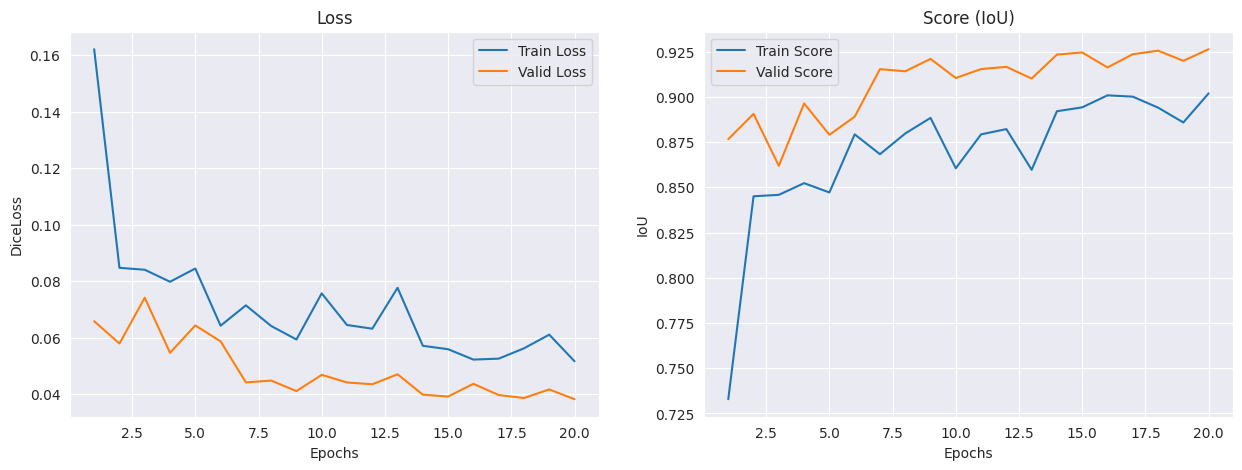

In [10]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

In [11]:
# bestmodelの読み込み
checkpoint = torch.load(CHECKPOINT_PATH_UNet + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

[2, 46, 33, 4, 59, 45]


/tmp/ipykernel_1749/2669564127.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
/tmp/ipykernel_1749/2669564127.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


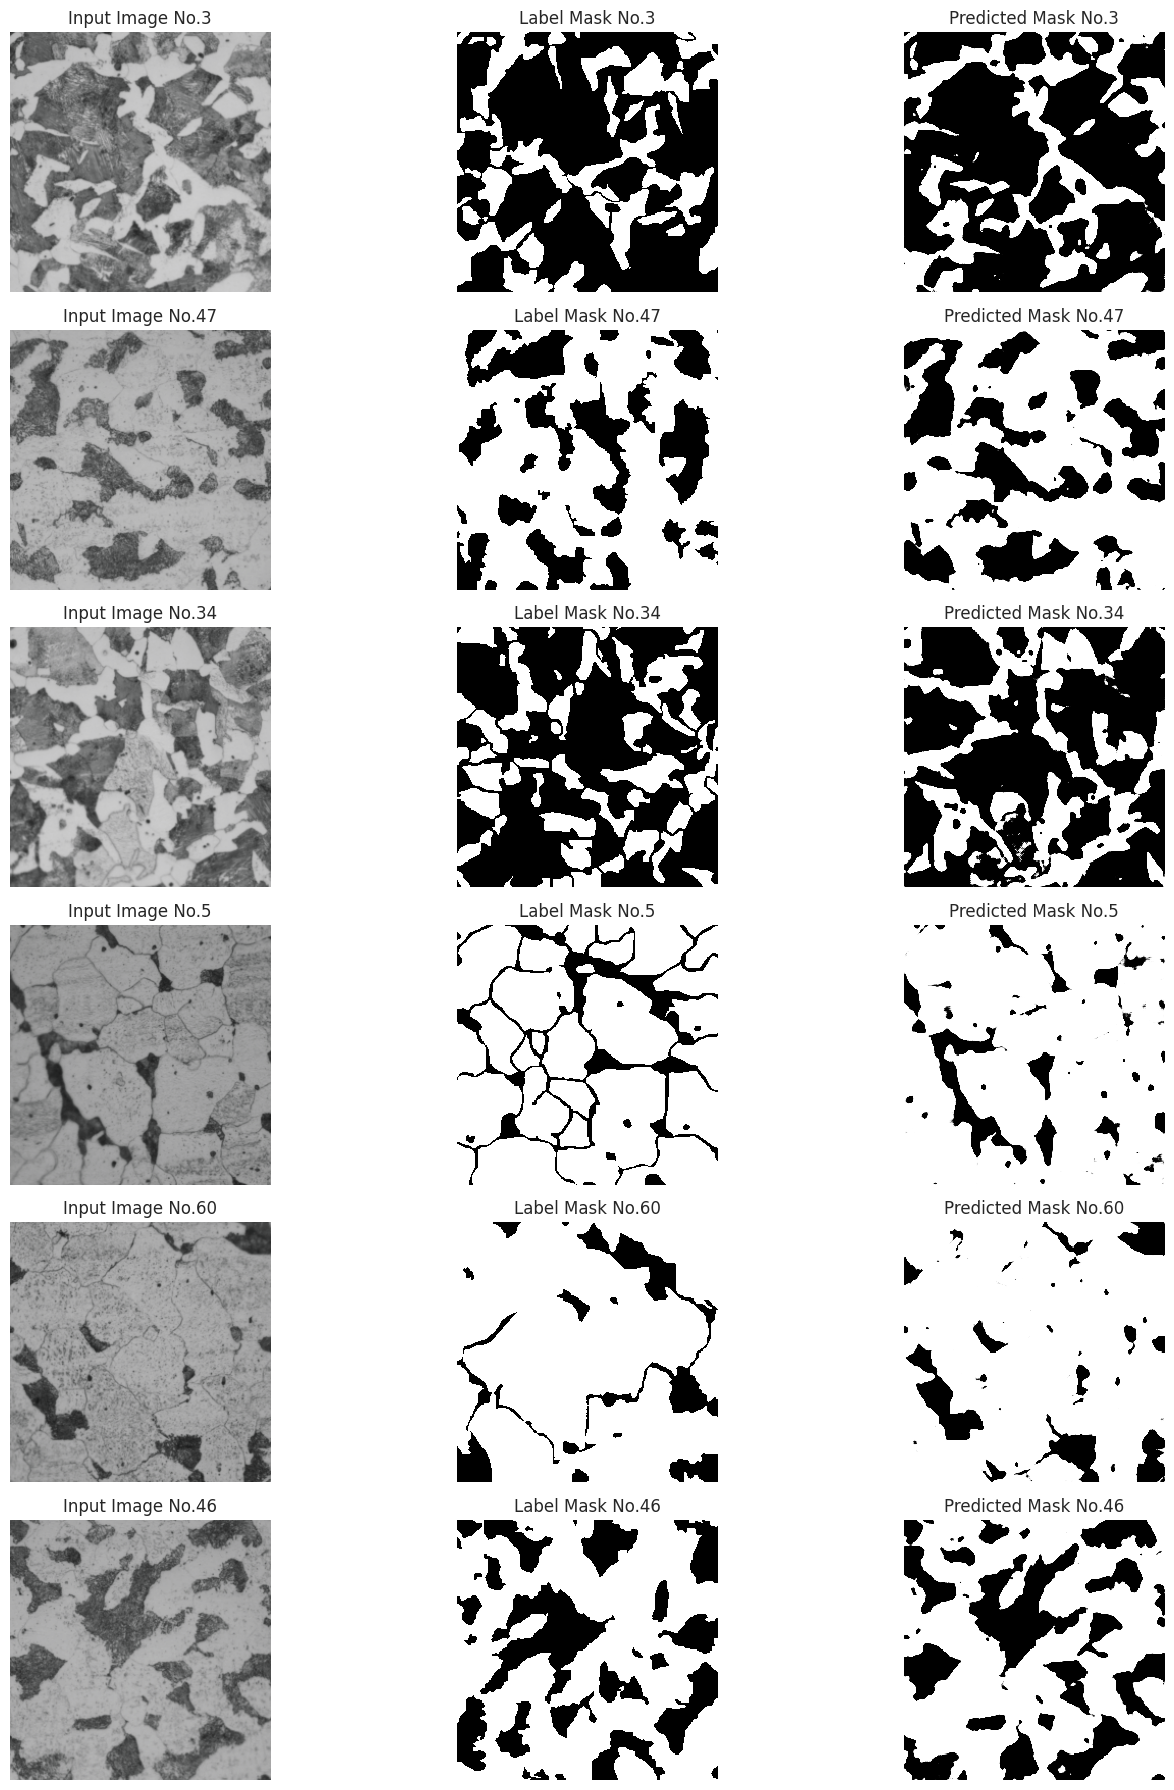

In [12]:
def visualize_predict(model, n_images, num_range):
    images = random.sample(range(0, num_range), n_images)
    print(images)
    # figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    figure, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 18))
    
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            o = model(data)
            break
    for i in range(0, len(images)):
        img_no = images[i]
        tm=o[i][0].data.cpu().numpy()
        img = data[i].data.cpu()
        msk = mask[i].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[i, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 2].set_title(f"Predicted Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6, num_range)